In [1]:
import numpy as np 
import pandas as pd
import os

In [3]:
!pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=8944a90197fb588fcda58761aac6d402a81e13635651430eb2a015bec564ec22
  Stored in directory: c:\users\swast\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [7]:
import wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py")

100% [..............................................................................] 13881 / 13881

'helper_prabowo_ml.py'

In [8]:
!pip install transformers

     ---------------------------------------- 7.0/7.0 MB 6.6 MB/s eta 0:00:00
     -------------------------------------- 200.1/200.1 kB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 6.3 MB/s eta 0:00:00


In [9]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swast\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Loading the train, validation and test datasets

In [11]:
train = pd.read_csv("data/training.csv")
val = pd.read_csv("data/validation.csv")
test = pd.read_csv("data/test.csv")

## Combining the train, validation and test datasets into a single dataframe

In [12]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,text,label
0,11451,i did feeling jolly accomplished currently,1
1,13691,im not trying to disagree with same sex interc...,4
2,9410,i feel what its like to be popular,1
3,9635,i feel oddly reassured to hear you say that,1
4,132,i have a lot of feelings of love and warmth fo...,3


In [13]:
df.drop('index',axis=1,inplace=True)

In [14]:
df.shape

(2000, 2)

## Text Preprocessing

In [15]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [17]:
preprocessed_df = preprocess_data(df,'text')
preprocessed_df.head()

,text,label
0,feeling jolly accomplished currently,1
1,m trying disagree sex intercourse feels weird gt,4
2,feel popular,1
3,feel oddly reassured hear say,1
4,ot feelings love warmth sometimes think tortured,3


In [18]:
preprocessed_df['num_words'] = preprocessed_df.text.apply(len)

In [19]:
preprocessed_df.head()

,text,label,num_words
0,feeling jolly accomplished currently,1,36
1,m trying disagree sex intercourse feels weird gt,4,48
2,feel popular,1,12
3,feel oddly reassured hear say,1,29
4,ot feelings love warmth sometimes think tortured,3,48


In [39]:
encoded_labels = {0:'sad',
    1:'joy',
    2:'love',
    3:'anger',
    4:'fear',
    5:'suprise'} 

## Train-Test Split

In [23]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.label)

## Loading the Tokenizer class and pretrained BERT model

In [24]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


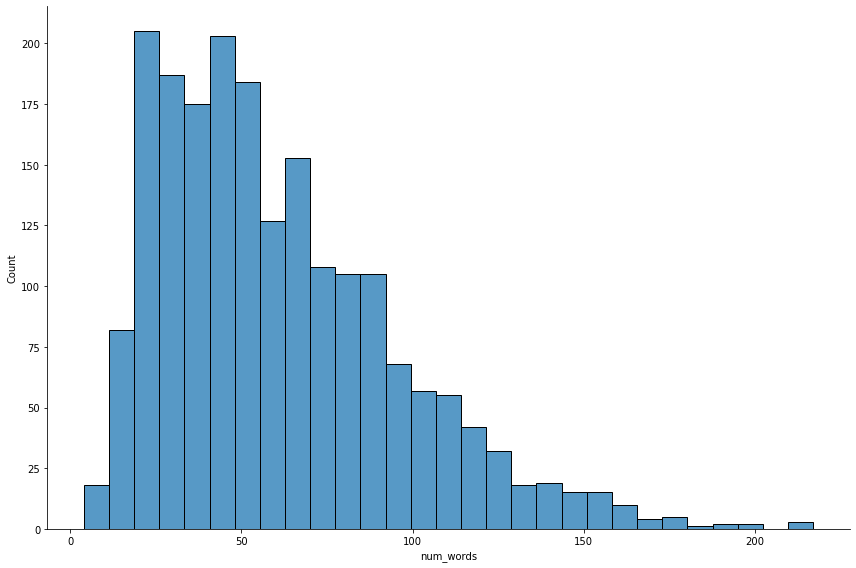

In [26]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [48]:
max_len = 39

## Text Tokenization

In [49]:
X_train = tokenizer(text=train_data.text.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.text.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [50]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [51]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Compiling the model

In [52]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Encoding the emotion labels

In [53]:
train_data['Label'] = train_data.label.map(encoded_labels)
test_data['Label'] = test_data.label.map(encoded_labels)

In [54]:
train_data.head()

,text,label,num_words,Label
1218,would feel ungrateful didnt thank know,0,38,sad
1763,suppose natural id start feel little homesick ...,0,67,sad
254,feel even dangerous though youre pouring time ...,3,102,anger
317,dont christmas feel lost meaning,0,32,sad
957,found life coaching hundreds people past years...,0,159,sad


In [55]:
test_data.head()

,text,label,num_words,Label
266,feel nervous going back america knowing expect...,4,56,fear
1329,feel uncontrollably agitated idea,4,33,fear
753,spring fling feeling flower unfurling artistic...,1,66,joy
50,feel virtuous seconds reflect spend something ...,1,97,joy
65,feel bit stupid writing true,0,28,sad


## Generating the model summary and plot

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 39)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 39)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             109482240   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 768)         0           ['tf_bert_model[1][0]']    

In [57]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Training and fine-tuning the pretrained BERT model 

In [59]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.label))
             )

Epoch 1/10
44/44 [==============================] - 386s 9s/step - loss: 1.2275 - balanced_accuracy: 0.5607 - val_loss: 1.0756 - val_balanced_accuracy: 0.5983
Epoch 2/10
44/44 [==============================] - 379s 9s/step - loss: 0.8549 - balanced_accuracy: 0.7129 - val_loss: 0.7558 - val_balanced_accuracy: 0.7383
Epoch 3/10
44/44 [==============================] - 367s 8s/step - loss: 0.5147 - balanced_accuracy: 0.8321 - val_loss: 0.6905 - val_balanced_accuracy: 0.7733
Epoch 4/10
44/44 [==============================] - 373s 9s/step - loss: 0.3103 - balanced_accuracy: 0.9100 - val_loss: 0.5573 - val_balanced_accuracy: 0.8167
Epoch 5/10
44/44 [==============================] - 403s 9s/step - loss: 0.1717 - balanced_accuracy: 0.9586 - val_loss: 0.5623 - val_balanced_accuracy: 0.8350
Epoch 6/10
44/44 [==============================] - 393s 9s/step - loss: 0.1178 - balanced_accuracy: 0.9750 - val_loss: 0.5532 - val_balanced_accuracy: 0.8417
Epoch 7/10
44/44 [============================

## Analyzing model performance

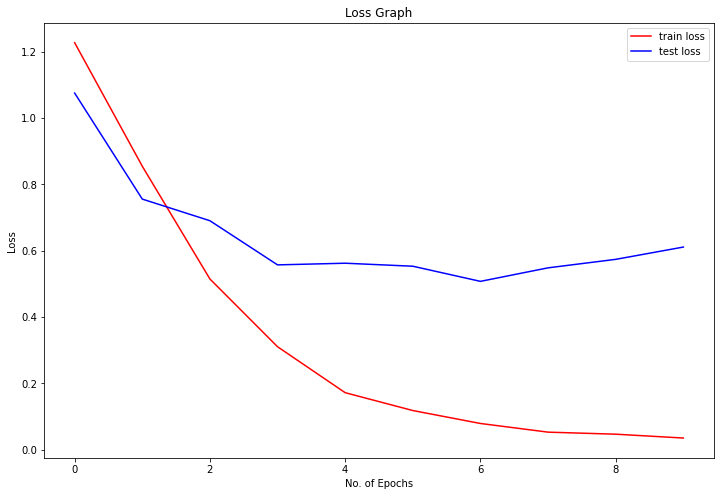

In [60]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

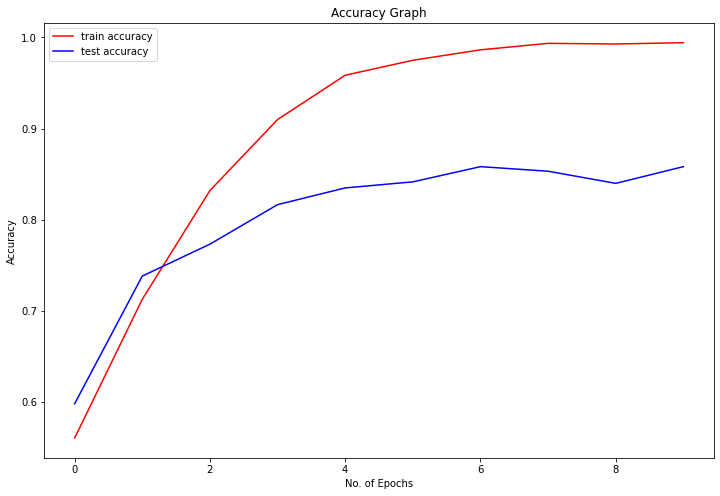

In [61]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [62]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [64]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 51s 2s/step - loss: 0.6110 - balanced_accuracy: 0.8583
Test Categorical Cross-Entropy Loss: 0.6109983325004578
Test Categorical Accuracy: 0.8583333492279053


In [66]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.label,test_predictions))

19/19 [==============================] - 49s 2s/step
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       167
           1       0.85      0.93      0.89       213
           2       0.64      0.46      0.53        46
           3       0.89      0.86      0.88        78
           4       0.85      0.82      0.83        71
           5       0.71      0.80      0.75        25

    accuracy                           0.86       600
   macro avg       0.81      0.79      0.80       600
weighted avg       0.86      0.86      0.85       600



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.